# ***Computer Vision Final Project: Breast Cancer Tumor Classification***
## Section 1 Spring 2023
### Nicholas Lee, Nic Brathwaite, Amir Moayed

# Baseline Models

### Setup

In [2]:
# Google packages
from google.colab import drive
from google.colab import files
# from google.colab.patches import cv2_imshow

# base packages
import os
import warnings
import random
from datetime import date
import re
from tqdm.notebook import tqdm # progress bar library
import glob

# DS packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# image packages
import PIL
import urllib
# import cv2
# from skimage.color import rgb2gray
# import skimage.io as skio

# ML packages
# import scipy as sc
# import sklearn as sk
import tensorflow as tf

%matplotlib inline

In [ ]:
gpu_instance = True

if gpu_instance == True: 
  tf.config.list_physical_devices()  
  tf.test.gpu_device_name()
  !export CUDA_VISIBLE_DEVICES=0  

# Github connection

[See here for instructions](https://towardsdatascience.com/using-git-with-colab-via-ssh-175e8f3751ec)

Thinking of using for version control and final project submission

# Functions

In [3]:
# pickle object for later
import pickle

def pickler(ob, pklFileName):
  """ 
    Create pickle object to load later or in different environments for use later

    ob: object, python object intended to pickle
    pklFileName: string, name of the pickle file e.g. "User/content/drive/209/ThisDataFrame.pkl"
  """
  
  with open(pklFileName, "wb+") as f:
    pickle.dump(ob, f)

def load_pickles(pklFilePath):
  """
    path: string, path to object
    pklFileName: string, pickle file name with extension .pkl
  """

  return pd.read_pickle(pklFilePath)

In [4]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


## File Paths

In [ ]:
# Paths
main_path = "/content/drive/MyDrive/"

project_path = "w281_final_project/"
data_path_benign = "Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/"
data_path_malignant = "Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/"
save_path = "".join([date.today().strftime('%Y%m%d'), "_baseline_models/"])

project_path = "".join([main_path, project_path])
data_path_benign = "".join([project_path, data_path_benign])
data_path_malignant = "".join([project_path, data_path_malignant])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("data path benign: ", data_path_benign)
print("data path malignant: ", data_path_malignant)
print("save path: ", save_path)

project path:  /content/drive/MyDrive/w281_final_project/
data path benign:  /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/
data path malignant:  /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/
save path:  /content/drive/MyDrive/w281_final_project/20230323_baseline_models/


In [ ]:
# Benign and Malignant Directories
benign_directory = "".join([data_path_benign, "SOB/"])
malignant_directory = "".join([data_path_malignant, "SOB/"])

print("SOB benign", benign_directory)
print("SOB malignant", malignant_directory)

SOB benign /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/
SOB malignant /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/


# Hard Coded Variables

In [ ]:
# Folders & Resolution
forty = "40X"
one_hundred = "100X"
two_hundred = "200X"
four_hundred = "400X"


In [ ]:
class fileMetaData: 
  def __init__(fileName): 
    self.fileName = fileName

In [ ]:
labels = {
    "BIOPSY_PROCEDURE": "", 
    "TUMOR_CLASS": "", 
    "TUMOR_TYPE":"", 
    "YEAR": "",
    "SLIDE_ID": "", 
    "MAGNIFICATION": "",
    "SEQ":""
}

In [ ]:
# categories
categories = {'B': 'Benign',
              'M': 'Malignant',
              'A': 'Adenosis',
              'F': 'Fibroadenoma',
              'TA': 'Tubular Adenoma',
              'PT': 'Phyllodes Tumor',
              'DC': 'Ductal Carcinoma',
              'LC': 'Lobular Carcinoma',
              'MC': 'Mucinous Carcinoma (Colloid)',
              'PC': 'Papillary Carcinoma'}

# Creating Meta Data

In [ ]:
data_dir = "/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"

In [ ]:
indivdual_files = glob.glob(data_dir + "/**/*.png", recursive=True)

In [ ]:
len(indivdual_files)

7909

In [ ]:
def metaDataCreator(filePath):
  """ Separate out the parts of a file path to get the annotations
  
  INPUT: Full path to file
  OUTPUT: metadata dictionary  
  """

  metaKeys = ['BIOPSY_PROCEDURE',
            'TUMOR_CLASS',
            'TUMOR_TYPE',
            'YEAR',
            'SLIDE_ID',
            'MAGNIFICATION',
            'SEQ']

  fileName = os.path.basename(filePath)
  metaValues = re.split("[\._-]", fileName)[:-1]

  if len(metaValues) == 7: 
    metaData = {metaKeys[i]:metaValues[i] for i in range(len(metaValues))}
    metaData["FULL_PATH"] = filePath
    metaData["BASE_NAME"] = fileName
    return metaData
 
  else: 
    return None

In [ ]:
# Create dataframe constructor
annotations = [metaDataCreator(f) for f in indivdual_files]

# remove none and create dataframe
df_fA = pd.DataFrame(list(filter(None, annotations)))

# remove variable we no longer will need
del(annotations)

In [ ]:
df_fA.head()

,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-007.png


In [ ]:
df_fA.shape

(7909, 9)

In [ ]:
df_fA.describe(include = 'all')

,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
count,7909,7909,7909,7909,7909,7909,7909,7909,7909
unique,1,2,8,2,81,4,83,7909,7909
top,SOB,M,DC,14,13412,100,004,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-004.png
freq,7909,5429,3451,7844,246,2081,318,1,1


In [ ]:
pklFileName = os.path.join("/content/drive/MyDrive/w281_final_project/Data/pickles", "metaData.pkl")

pickler(df_fA, pklFileName)

# Create tensorflow dataset to use in models

In [15]:
df_fA = load_pickles(os.path.join("/content/drive/MyDrive/w281_final_project/Data/pickles", "metaData.pkl"))

In [16]:
df_fA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BIOPSY_PROCEDURE  7909 non-null   object
 1   TUMOR_CLASS       7909 non-null   object
 2   TUMOR_TYPE        7909 non-null   object
 3   YEAR              7909 non-null   object
 4   SLIDE_ID          7909 non-null   object
 5   MAGNIFICATION     7909 non-null   object
 6   SEQ               7909 non-null   object
 7   FULL_PATH         7909 non-null   object
 8   BASE_NAME         7909 non-null   object
dtypes: object(9)
memory usage: 556.2+ KB


Some bias will be inherent in the data set. There are twice as many malignant images as benign. 

In [ ]:
df_fA.loc[:, "TUMOR_CLASS"].value_counts()

M    5429
B    2480
Name: TUMOR_CLASS, dtype: int64

In [ ]:
df_fA.loc[:, ["TUMOR_CLASS", "TUMOR_TYPE"]].value_counts()

TUMOR_CLASS  TUMOR_TYPE
M            DC            3451
B            F             1014
M            MC             792
             LC             626
B            TA             569
M            PC             560
B            PT             453
             A              444
dtype: int64

In [ ]:
# df_fA.loc[:, ['FULL_PATH', 'TUMOR_CLASS']].to_csv("/content/drive/MyDrive/w281_final_project/Data/tf_data/annotations.csv")

In [ ]:
df_fA['MAGNIFICATION'].unique()

array(['100', '200', '400', '40'], dtype=object)

In [ ]:
# Define the data directory and image dimensions
batch_size, img_height, img_width, channels = 32, 470, 700, 3

In [ ]:
# Define the data directory and image dimensions
batch_size, img_height, img_width, channels = 32, 470, 700, 3

filename = df_fA.loc[0, "FULL_PATH"]

img = tf.keras.preprocessing.image.load_img(
            filename,
            target_size=(img_height, img_width)
        )
        

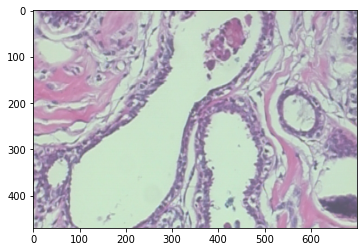

In [ ]:
plt.imshow(img)

In [ ]:
image_array = tf.keras.preprocessing.image.img_to_array(img)

In [ ]:
type(image_array)

numpy.ndarray

In [ ]:
image_array.shape

(470, 700, 3)

In [ ]:
df_fA.query(f'MAGNIFICATION == "{m}"').reset_index().loc[:5, "FULL_PATH"]

0    /content/drive/MyDrive/w281_final_project/Data...
1    /content/drive/MyDrive/w281_final_project/Data...
2    /content/drive/MyDrive/w281_final_project/Data...
3    /content/drive/MyDrive/w281_final_project/Data...
4    /content/drive/MyDrive/w281_final_project/Data...
5    /content/drive/MyDrive/w281_final_project/Data...
Name: FULL_PATH, dtype: object

In [ ]:
m = "40"
filenames = df_fA.query(f'MAGNIFICATION == "{m}"').reset_index().loc[:5, "FULL_PATH"]
labels = np.array(df_fA.loc[:5, "TUMOR_CLASS"])

In [ ]:
labels[labels == "B"] = 0
labels[labels == "M"] = 1

In [ ]:
print(filenames)
print(labels)

0    /content/drive/MyDrive/w281_final_project/Data...
1    /content/drive/MyDrive/w281_final_project/Data...
2    /content/drive/MyDrive/w281_final_project/Data...
3    /content/drive/MyDrive/w281_final_project/Data...
4    /content/drive/MyDrive/w281_final_project/Data...
5    /content/drive/MyDrive/w281_final_project/Data...
Name: FULL_PATH, dtype: object
[0 0 0 0 0 0]


In [ ]:
images = np.empty((len(filenames), img_height, img_width, channels), dtype=np.uint8) # dimensions, height, width, channels, labels
for i, filename in tqdm(enumerate(filenames), total = len(filenames)):
        img = tf.keras.preprocessing.image.load_img(
            filename,
            target_size=(img_height, img_width)
        )
        print(img.size)
        images[i] = tf.keras.preprocessing.image.img_to_array(img)

  0%|          | 0/6 [00:00<?, ?it/s]

(700, 470)
(700, 470)
(700, 470)
(700, 470)
(700, 470)
(700, 470)


In [ ]:
images.shape

(6, 470, 700, 3)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((images,labels))

In [ ]:
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(470, 700, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
for i in dataset:
  print(i)

# Label encoding
0 - Benign  
1 - Malignant

one-hot encoding for subcategories


In [ ]:
# Define the data directory and image dimensions
img_height, img_width = 470, 700

for m in df_fA['MAGNIFICATION'].unique(): 
  # Load the image filenames and labels
  filenames = df_fA.query(f'MAGNIFICATION == "{m}"').loc[:, "FULL_PATH"]
  labels = df_fA.query(f'MAGNIFICATION == "{m}"').loc[:, "TUMOR_CLASS"].copy()

  # convert to binary labels
  labels[labels == "B"] = 0
  labels[labels == "M"] = 1
  labels = labels.astype(np.float32) # tensor only takes floats(?)

  # Create a TensorFlow session and configure it to use the GPU
  config = tf.compat.v1.ConfigProto()
  config.gpu_options.allow_growth = True
  session = tf.compat.v1.Session(config=config)

  # Load the image arrays into a numpy array
  images = np.empty((len(filenames), img_height, img_width, 3), dtype=np.uint8)
  with session.as_default(): # having this inside the for loop dramatically increased the speed. Helps to reconnect again. Slowed down eventually though
    for i, filename in tqdm(enumerate(filenames), total = len(filenames)):
        img = tf.keras.preprocessing.image.load_img(
            filename,
            target_size=(img_height, img_width)
        )
        images[i] = tf.keras.preprocessing.image.img_to_array(img)

  # Test the session by running a TensorFlow command that uses the GPU
  with session.as_default():
    ## Saving images as dataset incase we want to repeat the train test split
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Create a directory if it does not exist
    tf.io.gfile.makedirs(f"/content/drive/MyDrive/w281_final_project/Data/tf_data/images_{m}X")

    # Save the dataset to disk
    tf.data.Dataset.save(dataset, f"/content/drive/MyDrive/w281_final_project/Data/tf_data/images_{m}X")
  




  0%|          | 0/1820 [00:00<?, ?it/s]

# Method 2 for creating dataset. 
The first method did not include the labels for the images which concerns me. 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory?authuser=1

This dataset will be for classifying images as either benign or malignant to be used for binary crossentropy during training. This will serve as a good starting point for model building. In the next step I will create the sub classes

In [ ]:
dataDir = "/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"

Problem is that the subclasses at different magnifications is not captured this way which could make training the model difficult. Might have to rearrange the folderstructure to accomplish this view since magnifications are split at the very end of the folder tree

In [ ]:
# Creates tf dataset for all images 7909 with benign and malignant labels
dataset = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(460, 700),
    shuffle=True,
    seed=26,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 7909 files belonging to 2 classes.


In [ ]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 460, 700, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# check class names in dataset
dataset.class_names

['benign', 'malignant']

In [ ]:
# save dataset for use later in model building. Takes a long time. 
dataset.save("/content/drive/MyDrive/w281_final_project/Data/tf_data/full_image_set")

# Create dataset for subclasses


# Method 3
Give images are organized in subfolders

In [8]:
img_width = 700
img_height = 470
batch_size = 32

dataDir = "/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"

In [10]:
# imagedata generator and flow from directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
datagen = ImageDataGenerator(
    rescale = 1./255, # normalize the data
    horizontal_flip = False,
    vertical_flip = False,
    data_format = "channels_last",
    validation_split = 0.1,
    dtype = tf.float32
)

In [12]:
train_generator = datagen.flow_from_directory(
    directory = dataDir, 
    target_size=(img_height, img_width),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode='sparse', # because want to be integer represented
    shuffle = True,
    subset='training',
    seed = 26
)

Found 7119 images belonging to 2 classes.


In [ ]:
train_generator

In [ ]:
def training(): pass

for epoch in range(10): 
  num_batches = 0
  for x, y in ds_train: 
    num_batches += 1

    # do training
    training()

    if num_batches == 25: #len(train_dataset)/batch_size

# Method 4
File name contains label

In [37]:
dataDir = "/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"

df = load_pickles(os.path.join("/content/drive/MyDrive/w281_final_project/Data/pickles", "metaData.pkl"))

# starting with 40x
df.query('MAGNIFICATION == "40"').reset_index(inplace=True, drop = True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BIOPSY_PROCEDURE  7909 non-null   object
 1   TUMOR_CLASS       7909 non-null   object
 2   TUMOR_TYPE        7909 non-null   object
 3   YEAR              7909 non-null   object
 4   SLIDE_ID          7909 non-null   object
 5   MAGNIFICATION     7909 non-null   object
 6   SEQ               7909 non-null   object
 7   FULL_PATH         7909 non-null   object
 8   BASE_NAME         7909 non-null   object
dtypes: object(9)
memory usage: 556.2+ KB


,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-007.png


In [71]:
file_paths = df['FULL_PATH'].values
labels = df['TUMOR_TYPE'].values

In [73]:
# convert labels to numeric representation
from sklearn.preprocessing import LabelEncoder

depth = len(set(labels))
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(labels)

labels = tf.one_hot(labels, depth = depth)


In [74]:
ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels)) # mapping like a zip in python

def read_image(image_file_path, label): 
  image = tf.io.read_file(image_file_path) # read in image
  image = tf.image.decode_image(image, channels = 3, dtype = tf.float32) # preserving RGB colors with channels = 3. Reads array 
  return image, label

def augment(image, label): 
  # data augmentation here
  return image, label

In [75]:
ds_train = ds_train.map(read_image).map(augment).batch(32)

In [76]:
for epoch in range(10): 
  for x, y in ds_train: 
    # train here
    pass

KeyboardInterrupt: ignored

In [77]:
from tensorflow import keras
from tensorflow.keras import layers

In [78]:
model = keras.Sequential([
    layers.Input((28,28,1)),
    layers.Conv2D(16,3, padding = 'same'),
    layers.Conv2D(32,3,padding = 'same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8)
])

In [79]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss = [
        keras.losses.CategoricalCrossentropy(from_logits = True),
    ],
    metrics=['accuracy'],
)

In [ ]:
model.fit(ds_train,
          epochs=10,
          verbose=2)